# Gamma-gamma model

Comparison with lifetimes

**Reference**:Fader, P. S., & Hardie, B. G. (2013). The Gamma-Gamma model of monetary value. February, 2, 1-9.

http://www.brucehardie.com/notes/025/gamma_gamma.pdf

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pymc_marketing import clv

In [3]:
# Extra dependency for this notebook
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter

## Load data

In [4]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


## Lifetimes implementation

In [5]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [6]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


In [7]:
avg_profit = ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],
    summary_with_money_value['monetary_value']
)
avg_profit.head(10)

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

In [8]:
avg_profit.mean()

35.25295817604995

## PyMC Marketing implementation

We can use the pre-built PyMC Marketing implementation of the Gamma-Gamma model, which also provides nice ploting and prediction methods

In [9]:
dataset = pd.DataFrame({
    "customer_id": returning_customers_summary.index,
    "mean_transaction_value": returning_customers_summary["monetary_value"],
    "frequency": returning_customers_summary["frequency"],
})

In [10]:
model = clv.GammaGammaModel(
    data = dataset
)

In [11]:
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [12]:
model.fit(fit_method="map").posterior.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (chain: 1, draw: 1)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0
Data variables:
    p        (chain, draw) float64 6.249
    q        (chain, draw) float64 3.745
    v        (chain, draw) float64 15.45
Attributes:
    created_at:                 2023-06-23T16:00:07.763982
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.5.0>

In [13]:
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
/Users/michalraczycki/Documents/pymc-marketing/pymc_marketing/clv/models/basic.py:119: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [14]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.403,1.320,4.172,8.882,0.048,0.034,759.0,1010.0,1.01
q,3.787,0.295,3.252,4.338,0.011,0.007,780.0,1205.0,1.01
v,16.103,4.331,7.849,23.748,0.162,0.114,711.0,894.0,1.01


In [15]:
expected_spend = model.expected_customer_spend(
    customer_id=summary_with_money_value.index,
    mean_transaction_value=summary_with_money_value["monetary_value"],
    frequency=summary_with_money_value["frequency"],
)

In [16]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],24.707,0.519,23.711,25.640
x[2],19.000,1.336,16.283,21.313
x[3],35.165,0.909,33.520,36.919
x[4],35.165,0.909,33.520,36.919
x[5],35.165,0.909,33.520,36.919
x[6],71.376,0.614,70.299,72.560
x[7],19.000,1.336,16.283,21.313
x[8],35.165,0.909,33.520,36.919
x[9],27.317,0.398,26.510,27.986
x[10],35.165,0.909,33.520,36.919


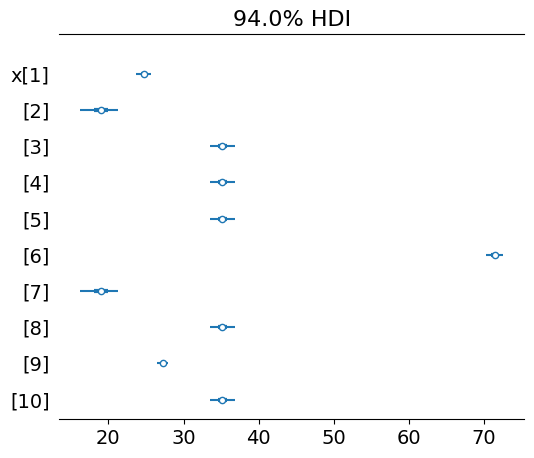

In [17]:
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True);

In [18]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,35.247,0.618,34.078,36.394


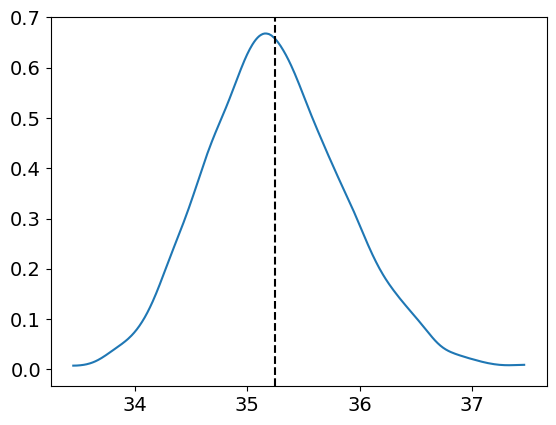

In [19]:
az.plot_dist(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")